In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class PoissonProcess():
    def __init__(self, lam_func, T, nhpp = False):
        self.lam_func = lam_func
        self.T = T
        t_list = np.linspace(0,T,1000)
        self.max_lam = np.max([self.lam_func(t) for t in t_list]) * 1.01
        assert np.min([self.lam_func(t) for t in t_list]) >= 0
        self.simulate(nhpp)
        
    def simulate(self, nhpp):
        N = np.random.poisson(lam = self.T * self.max_lam)
        arrival_time_ls = np.sort(np.random.uniform(0, self.T, size=N))
            
        def accept_reject():
            keep_prob = [self.lam_func(t)/self.max_lam for t in arrival_time_ls]
            whether_keep = [bool(np.random.binomial(n=1,p=prob)) for prob in keep_prob]
            self.arrival_time_ls = arrival_time_ls[whether_keep]
        
        def thinning():
            thinned = []
            for arrival in arrival_time_ls:
                #print(self.lam_func(arrival), self.max_lam)
                U = np.random.uniform()
                if U <= self.lam_func(arrival)/self.max_lam:
                    thinned.append(arrival)
            self.arrival_time_ls = thinned
        
        if nhpp:
            #accept_reject()
            thinning()
        if not nhpp: 
            self.arrival_time_ls = arrival_time_ls[arrival_time_ls <= self.T]
        
        #for graphing purposes
        inter_arrivals = []
        for i in range(len(self.arrival_time_ls)):
            if i == 0:
                inter_arrivals.append(self.arrival_time_ls[i])
                continue
            inter_arrivals.append(self.arrival_time_ls[i] - self.arrival_time_ls[i-1])
        self.inter_arrivals = inter_arrivals  

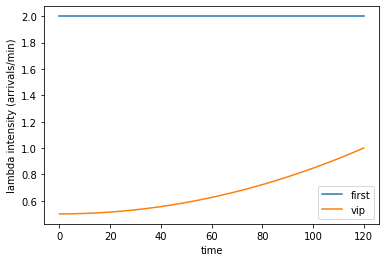

In [3]:
t_list = np.linspace(0,120,1000)

def lambda1(t=None):
    return 2
def lambda2(t=None):
    return t**2/28800 + 0.5

lam_list1 = [lambda1(t) for t in t_list]
plt.plot(t_list, lam_list1, label = 'first')
lam_list2 = [lambda2(t) for t in t_list]
plt.plot(t_list, lam_list2, label = 'vip')
plt.xlabel('time')
plt.ylabel('lambda intensity (arrivals/min)')
plt.legend()

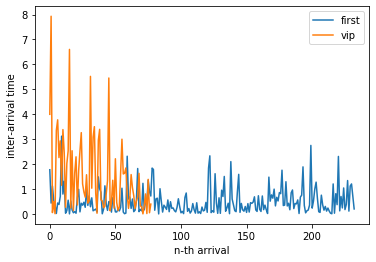

In [54]:
test1 = PoissonProcess(lambda1, 120, nhpp = False)
inter_arrivals1 = test1.inter_arrivals
test2 = PoissonProcess(lambda2, 120, nhpp = True)
inter_arrivals2 = test2.inter_arrivals
#print(test2.arrival_time_ls)
plt.plot(np.arange(len(inter_arrivals1)), inter_arrivals1, label = 'first')
plt.plot(np.arange(len(inter_arrivals2)), inter_arrivals2, label = 'vip')
plt.xlabel('n-th arrival')
plt.ylabel('inter-arrival time')
plt.legend()

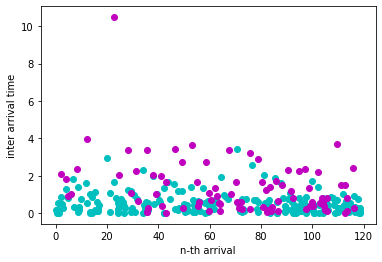

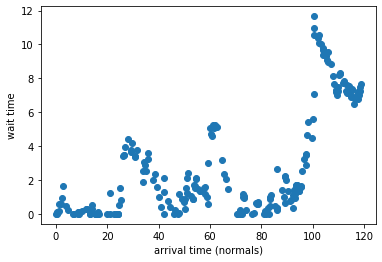

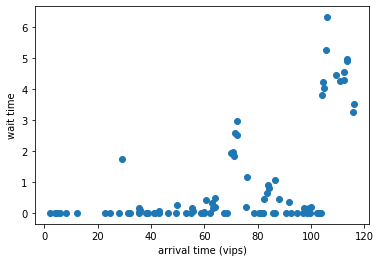

In [106]:
class Customer():
    def __init__(self, customer_type, arrival_time, service_time):
        self.type = customer_type
        self.arrival_time = arrival_time
        self.service_time = service_time
    def print_(self):
        print(self.type, 'arrival time:', self.arrival_time, 'service time:', self.service_time)
        
class single_day():
    def __init__(self):
        def lambda1(t=None):
            return 2
        def lambda2(t=None):
            return t**2/28800 + 0.5
        self.stream_norm = PoissonProcess(lambda1, T = 120, nhpp = False)
        self.stream_vip = PoissonProcess(lambda2, T = 120, nhpp = True)
        self.arrivals_norm = self.stream_norm.arrival_time_ls
        self.arrivals_vip = self.stream_vip.arrival_time_ls
        self.inter_arrivals_norm = self.stream_norm.inter_arrivals #for graphing purposes
        self.inter_arrivals_vip = self.stream_vip.inter_arrivals #for graphing
        self.service_times = np.random.exponential(1/(60/35), len(self.arrivals_norm) + len(self.arrivals_vip))
        dict = {}
        for arrival_time in self.arrivals_norm:
            C = Customer('normal', arrival_time, self.service_times[len(dict)])
            dict[C] = arrival_time
        for arrival_time in self.arrivals_vip:
            C = Customer('vip', arrival_time, self.service_times[len(dict)])
            dict[C] = arrival_time    
        self.combined = [C for C, t in sorted(dict.items(), key=lambda x: x[1])] #list of combined customers sorted by arrival time 
        self.priority_serve()
        
    def priority_serve(self):
        n_servers = 2
        next_idle_times = np.zeros(n_servers)
        line_norm, line_vip = [], []
        wait_times_norm, wait_times_vip = [], []
        while len(self.combined) > 0 or len(line_norm) > 0 or len(line_vip) > 0:
            
            ready_time = min(next_idle_times)
            server_index = np.argmin(next_idle_times)
            def serve(line, server_index):
                server_ready_time = next_idle_times[server_index]
                C = line[0]
                return_val = line[1:]

                start_time = max(server_ready_time, C.arrival_time)
                wait_time = max(0, start_time - C.arrival_time)
                finish_time = start_time + C.service_time
                next_idle_times[server_index] = finish_time
                
                if C.type == 'normal':
                    wait_times_norm.append(wait_time)
                elif C.type == 'vip':
                    wait_times_vip.append(wait_time)
                return return_val
            
            if len(self.combined) == 0:
                #print(len(line_norm), len(line_vip))
                if server_index == 0:
                    if len(line_norm) > 0:
                        line_norm = serve(line_norm, 0)
                    elif len(line_norm) == 0:
                        line_vip = serve(line_vip, 1)
                elif server_index == 1:
                    if len(line_vip) > 0:
                        line_vip = serve(line_vip, 1)
                    elif len(line_vip) == 0:
                        line_norm = serve(line_norm, 1)
            
            #if the server was ready before the new customer arrived, or if there are no new customers but still people in lines
            #     The reason we don't run if ready_time > C.arrival_time is because the server is not yet ready to take a 
            #     customer yet, and it can be problematic if we just start running. Take for example the situation where 
            #     server1 is the next ready server at time 30, and after the new customer C arrives the normal queue has 
            #     customer C who arrived at time 25 whose service time is 10, and the vip queue is empty. We need to continue 
            #     adding people to queues before we process orders because if we immediately compute the situation where 
            #     server1 serves N, this is the incorrect process, because maybe vip customer V was set to arrive at time 26. 
            #     But as soon as C's arrival time is after the ready time, we have to start processing current queues because 
            #     the ready server has become idle.
            
            elif len(self.combined) > 0:
                new_customer = self.combined[0]
                #new_customer.print_()
                self.combined = self.combined[1:]
                if new_customer.type == 'normal':
                    line_norm.append(new_customer)
                elif new_customer.type == 'vip':
                    line_vip.append(new_customer)
                
                if new_customer.arrival_time >= ready_time:                    
                    if server_index == 0:
                        if len(line_norm) > 0:
                            line_norm = serve(line_norm, 0)
                        elif len(line_norm) == 0:
                            if new_customer.arrival_time >= next_idle_times[1]:
                                line_vip = serve(line_vip, 1)
                            elif new_customer.arrival_time < next_idle_times[1]:
                                None
                    elif server_index == 1:
                        if len(line_vip) > 0:
                            line_vip = serve(line_vip, 1)
                        elif len(line_vip) == 0:
                            line_norm = serve(line_norm, 1)            
                
        assert len(self.arrivals_vip) == len(wait_times_vip) and len(self.arrivals_norm) == len(wait_times_norm)    
        self.norm_wait_times = wait_times_norm
        self.vip_wait_times = wait_times_vip
    
    def plot(self):
        plt.figure(0)
        plt.scatter(self.arrivals_norm, self.inter_arrivals_norm, label = 'first', color = 'c')
        plt.scatter(self.arrivals_vip, self.inter_arrivals_vip, label = 'vip', color = 'm')
        plt.xlabel('n-th arrival')
        plt.ylabel('inter arrival time')
        #plt.legend()
        
        plt.figure(1)        
        plt.scatter(self.arrivals_norm, self.norm_wait_times)
        plt.xlabel('arrival time (normals)')
        plt.ylabel('wait time')
        
        plt.figure(2)
        plt.scatter(self.arrivals_vip, self.vip_wait_times)
        plt.xlabel('arrival time (vips)')
        plt.ylabel('wait time')

single_day().plot()












  0%|                                                                                           | 0/50 [00:00<?, ?it/s]










  8%|██████▋                                                                            | 4/50 [00:00<00:01, 37.00it/s]










 20%|████████████████▍                                                                 | 10/50 [00:00<00:00, 40.71it/s]










 32%|██████████████████████████▏                                                       | 16/50 [00:00<00:00, 43.64it/s]










 40%|████████████████████████████████▊                                                 | 20/50 [00:00<00:00, 42.20it/s]










 52%|██████████████████████████████████████████▋                                       | 26/50 [00:00<00:00, 44.57it/s]










 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:00<00:00, 45.14it/s]










 74%|████████████████████████████████████████████████████████████▋             


For customers who arrive from 12:45 to 1:00
     average waiting time for normal customers:  6.846568369597774
     average waiting time for vip customers:  0.7326555762069876


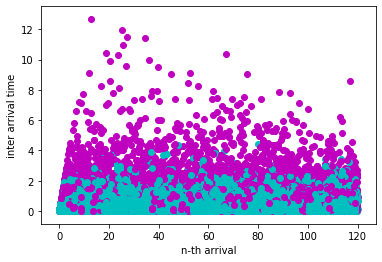

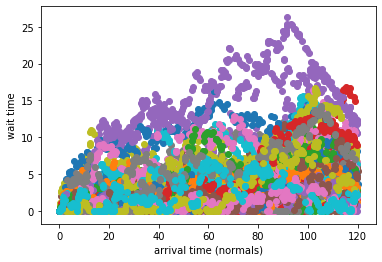

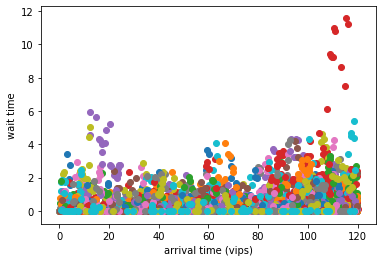

In [113]:
from tqdm import tqdm
fifty_days = []
for i in tqdm(range(50)):
    day = single_day()
    day.plot()
    fifty_days.append(day)

total_norm_waits = []
total_vip_waits = []
for day in fifty_days:
    n_norm = len(day.arrivals_norm)
    for i in range(n_norm):
        if day.arrivals_norm[i] >= 105:
            total_norm_waits.append(day.norm_wait_times[i])
    n_vip = len(day.arrivals_vip)
    for i in range(n_vip):
        if day.arrivals_vip[i] >= 105:
            total_vip_waits.append(day.vip_wait_times[i])
    
print()
print("For customers who arrive from 12:45 to 1:00")
print("     average waiting time for normal customers: ", sum(total_norm_waits)/len(total_norm_waits))
print("     average waiting time for vip customers: ", sum(total_vip_waits)/len(total_vip_waits))












  0%|                                                                                          | 0/500 [00:00<?, ?it/s]










  1%|▋                                                                                 | 4/500 [00:00<00:12, 39.03it/s]










  2%|█▍                                                                                | 9/500 [00:00<00:11, 41.09it/s]










  3%|██▍                                                                              | 15/500 [00:00<00:10, 44.34it/s]










  4%|███▏                                                                             | 20/500 [00:00<00:10, 44.47it/s]










  5%|████▏                                                                            | 26/500 [00:00<00:09, 47.44it/s]










  6%|█████                                                                            | 31/500 [00:00<00:13, 35.40it/s]










  7%|█████▊                                                                    

 53%|██████████████████████████████████████████▌                                     | 266/500 [00:05<00:06, 37.30it/s]










 54%|███████████████████████████████████████████▎                                    | 271/500 [00:05<00:05, 40.37it/s]










 55%|████████████████████████████████████████████▏                                   | 276/500 [00:06<00:05, 41.09it/s]










 56%|████████████████████████████████████████████▉                                   | 281/500 [00:06<00:05, 41.49it/s]










 57%|█████████████████████████████████████████████▊                                  | 286/500 [00:06<00:05, 41.82it/s]










 58%|██████████████████████████████████████████████▋                                 | 292/500 [00:06<00:04, 44.56it/s]










 59%|███████████████████████████████████████████████▌                                | 297/500 [00:06<00:04, 43.68it/s]










 61%|████████████████████████████████████████████████▍                               | 303


For customers who arrive from 12:45 to 1:00
     average waiting time for normal customers:  7.028003265752307
     average waiting time for vip customers:  0.6809449438405555


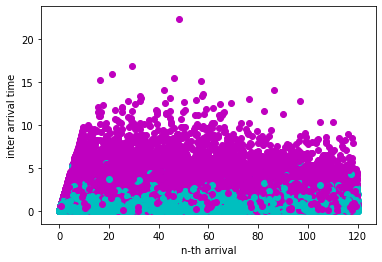

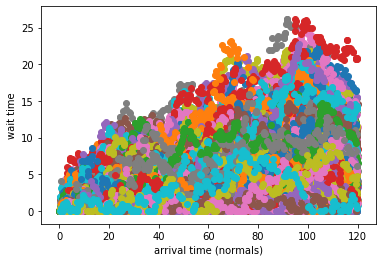

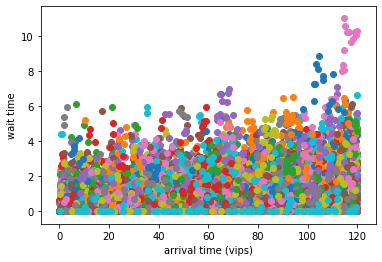

In [114]:
more_days = []
for i in tqdm(range(500)):
    day = single_day()
    day.plot()
    more_days.append(day)

total_norm_waits = []
total_vip_waits = []
for day in more_days:
    n_norm = len(day.arrivals_norm)
    for i in range(n_norm):
        if day.arrivals_norm[i] >= 105:
            total_norm_waits.append(day.norm_wait_times[i])
    n_vip = len(day.arrivals_vip)
    for i in range(n_vip):
        if day.arrivals_vip[i] >= 105:
            total_vip_waits.append(day.vip_wait_times[i])
    
print()
print("For customers who arrive from 12:45 to 1:00")
print("     average waiting time for normal customers: ", sum(total_norm_waits)/len(total_norm_waits))
print("     average waiting time for vip customers: ", sum(total_vip_waits)/len(total_vip_waits))